# IBM Streams database sample application
This sample demonstrates creating a Streams Python application to connect to a Db2 database, performing some analytics, and viewing the results.

In this notebook, you'll see examples of how to:
1. [Setup your database connection](#setup)
2. [Create the application](#create)
3. [Submit the application](#submit)
4. [Connect to the running application to view data](#view)

# Overview
**About the sample**

This application simulates data tuples that are inserted as rows into a Db2 database table.

**How it works**
   
The Python application created in this notebook is submitted to the IBM Streams service for execution. Once the application is running in the service, you can connect to it from the notebook to retrieve the results.

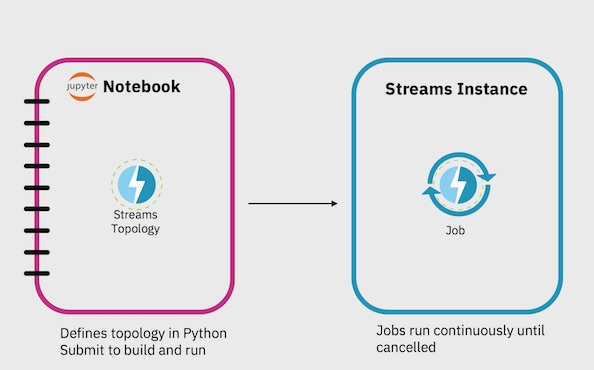


### Documentation
- [Streams Python development guide](https://ibmstreams.github.io/streamsx.documentation/docs/latest/python/)
- [Streams Python API](https://streamsxtopology.readthedocs.io/)



## <a name="setup"> </a> 1. Setup

### 1.1 Add credentials for the IBM Streams service

In order to submit a Streams application you need to provide the name of the Streams instance.

1. From the navigation menu, click **Services > Instances**.
2. Update the value of `streams_instance_name` in the cell below according to your Streams instance name.

In [ ]:
from icpd_core import icpd_util
streams_instance_name = "sample-streams" ## Change this to Streams instance

try:
    cfg=icpd_util.get_service_instance_details(name=streams_instance_name, instance_type="streams")
except TypeError:
    cfg=icpd_util.get_service_instance_details(name=streams_instance_name)

### 1.2 Import  the `streamsx.database` package and verify the package version

In [ ]:
import streamsx.database as db
import streamsx.topology.context
print("INFO: streamsx package version: " + streamsx.topology.context.__version__)
print("INFO: streamsx.database package version: " + db.__version__)

### <a name="credentials"> </a> 1.3 Configure the connection to Db2 Warehouse

We need Db2 credentials to connect to a Db2 database.

Select one of the following options:
* OPTION 1: Use external connection configured in Cloud Pak for Data
* OPTION 2: Use credentials from IBM cloud Db2 Warehouse service
* OPTION 3: Custom connetion, for example when running this notebook outside Cloud Pak for Data or having a database not located in IBM cloud or Cloud Pak for Data

### 1.3.1 OPTION 1: Use a configured external connection

Perform the steps [Connecting to data source](https://www.ibm.com/support/producthub/icpdata/docs/content/SSQNUZ_current/cpd/access/connect-data-sources.html) 
and create an external configuration for your Db2 connection.

List the connections with the cell below:

In [ ]:
ext_connections = icpd_util.get_connections('external')
print (ext_connections)

Change the `connection_name` and run the cell below 

In [ ]:
connection_name = 'auto-dashdb'
db2credentials = icpd_util.get_connection(connection_name, conn_class='external')
print (db2credentials)

### 1.3.2 OPTION 2: Use credentials from IBM cloud Db2 Warehouse service

1. Create a Db2 Warehouse service on IBM cloud.

  you need to have an IBM account to create a Db2 service.

  https://console.bluemix.net/catalog/?search=db2

2. Create a service credential for Db2 service on IBM cloud.
3. Copy the credentials in clipboard.
4. Uncomment and run the cell below
4. Paste the credentials into Db2 Warehouse credentials prompt below.

In [ ]:
#import getpass
#db2_service_credentials=getpass.getpass('Db2 Warehouse credentials:')

In [ ]:
#import json
#db2credentials = json.loads(db2_service_credentials)

### 1.3.3 OPTION 3: Custom connection

If you want to use another Db2 database, you can create a dict with the following attributes:

    {
      "username": "your-db-user-name",
      "password": "your-db-password",
      "jdbcurl": "jdbc:db2://your-db2-hostname:50000/your-database-name"
    }

In [ ]:
#db2credentials = {
#      "username": "your-db-user-name",
#      "password": "your-db-password",
#      "jdbcurl": "jdbc:db2://your-db2-hostname:50000/your-database-name"
#    }

# <a name="create"> </a> 2. Create the application
All Streams applications start with a Topology object, so start by creating one:


In [ ]:
#Imports
from streamsx.topology.topology import *
from streamsx.topology.context import *
from streamsx.topology.schema import StreamSchema
import streamsx.database as db

# create a Topology object
topo = Topology(name="DatabaseSample", namespace="sample")


### How to use the streamsx.database package
The streamsx.database package is the python wrapper for the [streamsx.jdbc](https://ibmstreams.github.io/streamsx.jdbc/doc/spldoc/html) toolkit

To interact with a Db2 database from Streams, you pass a SQL statement to the `streamsx.database.JDBCStatement` class.

`JDBCStatement` is the main class of `streamsx.database` package.

It executes a SQL statement and produces a [`Stream`](https://streamsxtopology.readthedocs.io/en/stable/streamsx.topology.topology.html#stream) of the results.
It needs at least two mandatory parameters, the first one is the input `Stream` and the second parameter is the database credentials in JSON format.

There are 2 ways to execute SQL statements using `db.JDBCStatement`:
- `Stream` containing the statements to execute. This is used for statements like creating or dropping tables.
- Set the `sql` parameter to the SQL statement and the `stream` contains the data you want to send to Db2. Use this when inserting data.

This application will show both ways. It executes SQL statements that: 
- Drop the Db2 table, if exists.
- Create a new table in a Db2 database.
- Insert some rows into the table.
- Select all rows from a table.

### Define the SQL statements and table name

In [ ]:
table_name = 'RUN_SAMPLE_DEMO'

# SQL statements
sql_drop   = 'DROP TABLE ' + table_name
sql_create = 'CREATE TABLE ' + table_name + ' (ID INT, NAME CHAR(30), AGE INT)'
sql_insert = 'INSERT INTO ' + table_name + ' (ID, NAME, AGE) VALUES (? , ?, ?)'
sql_select = 'SELECT * FROM ' + table_name

## <a name="drop"> </a> 2.1. Create the table


In the following step the `topo.source` creates a `Stream` containing the two SQL statements to drop and create the table. 

`db.JDBCStatement` executes the two statements in the input stream, so it will drop the table and create a new table.


In [ ]:
from streamsx.topology.schema import CommonSchema, StreamSchema
# The crt_table is a Stream containing the two SQL statements: sql_drop and sql_create
crt_table = topo.source([sql_drop, sql_create]).as_string()
# drop the table if exist and create a new table in database
crt_table.map(db.JDBCStatement(credentials=db2credentials), name='CREATE_TABLE', schema=CommonSchema.String)

## <a name="insert"> </a> 2.2. Insert streaming data into the table

Next, we generate a stream of data and insert it into the table we created.

The function `generate_data()` generates some data with schema `(ID INTEGER, NAME STRING, AGE INTEGER)` that will be inserted into the database.

Before it can be inserted in the database, we have to change the [schema](https://streamsxtopology.readthedocs.io/en/stable/streamsx.topology.schema.html) of the input data `Stream` to the [StreamsSchema](https://streamsxtopology.readthedocs.io/en/stable/streamsx.topology.schema.html#streamsx.topology.schema.StreamSchema) type, which is the format accepted by the `JDBCStatement` class.  See the [list of mappings from Python types to StreamSchema types](https://streamsxtopology.readthedocs.io/en/stable/streamsx.topology.schema.html#streamsx.topology.schema.StreamSchema)


The `gen_data` `Stream` contains the data produced by the `generate_data()` function.

We again use `db.JDBCStatement` but in the following step, it uses `gen_data` as input stream and the predefined `sql_insert` variable as the SQL statement.


In [ ]:
import random
import time

# generates some data with schema (ID, NAME, AGE)
def generate_data():
    counter = 0
    while True:
        #yield a random id, name and age
        counter = counter +1 
        yield  {"NAME": "Name_" + str(random.randint(0,500)), "ID": counter, "AGE": random.randint(10,99)}
        time.sleep(0.10)

# convert it to SPL schema for the database operator JDBCStatement
tuple_schema = StreamSchema("tuple<int64 ID, rstring NAME, int32 AGE>")
# Generates data for a stream of three attributes. Each attribute maps to a column using the same name of the Db2 database table.
gen_data = topo.source(generate_data, name="GeneratedData").map(lambda tpl: (tpl["ID"], tpl["NAME"], tpl["AGE"]),
                    schema=tuple_schema)

# insert generated rows into table
config_insert = {
    "sql": sql_insert,
    "sql_params": 'ID, NAME, AGE'
}
insertResults = gen_data.map(db.JDBCStatement(db2credentials, **config_insert), name='INSERT', schema=tuple_schema)

## <a name="select"> </a> 2.3. Retrieve data from the table
In this step the `JDBCStatement` runs the SQL statement `"SELECT * FROM RUN_SAMPLE_DEMO"` and returns the results in tuple schema `tuple<int64 ID, rstring NAME, int32 AGE>` .


In [ ]:
# select all rows from table
config_select = {
    "sql": sql_select
}
selectResults= gen_data.map(db.JDBCStatement(db2credentials, **config_select), name='SELECT', schema='tuple<int64 ID, rstring NAME, int32 AGE>')
selectResults.print()

# create a view to check retrieving data from a table
selectView = selectResults.view(name="selectRecords", description="Sample of selected records")

# <a name="submit"> </a> 3. Submit the application

A running Streams application is called a *job*. This next cell submits the application for execution and prints the resulting job id.

In [ ]:
from streamsx.topology import context

# Disable SSL certificate verification if necessary
cfg[context.ConfigParams.SSL_VERIFY] = False
# submit the topology 'topo'
submission_result = context.submit ("DISTRIBUTED", topo, config = cfg)

# The submission_result object contains information about the running application, or job
if submission_result.job:
    streams_job = submission_result.job
    print ("JobId: ", streams_job.id , "\nJob name: ", streams_job.name)

# <a name="view"> </a> 4. Use the View to access data from the job

Now that the job is started, use the View object you have already created to start retrieving data from a table in database.

In [ ]:
# Connect to the view and display the selected data
queue = selectView.start_data_fetch()
try:
    for val in range(20):
        print(queue.get(timeout=60))    
finally:
    selectView.stop_data_fetch()


## 5. See job status 

The tools available to monitor the running application depend on the version of Streams and your development environment.

- **If you are using a Cloud Pak for Data 3.5 project:**  When you submit the `Topology`, you create a new <i>job run</i>. The job represents the application and the job run represents a single instance of the running application. 

    1. Open your project and click on the **Jobs** tab. This will show a list of the project's jobs.
    1. Under the **Job name** column, find your job based on the `Job Name` [printed when you submitted the job](#launch). This will list all of the job runs for that job.
    1. Click the **Run name** to open the job run. The run name will be the same as the `Job Name` printed above.
    

- **For all other development environments and versions of Streams**, [see this page for more information](http://ibmstreams.github.io/streamsx.documentation/docs/spl/quick-start/qs-4).


# <a name="cancel"></a> 6. Cancel the job

The Streams job is running in the Streams service. You can cancel it within the notebook or delete it from **Projects** > **Jobs**.


In [ ]:
# cancel the job directly using the Job object
streams_job.cancel()

## Summary

We created an application which connects to Db2 database, dropped a table, created a table, inserted some rows into table and reads the rows.

After submitting the application to the Streams service, we checked the application logs to see the progress.

It is also possible to check the contents of the test table on Db2 console with the following command.

      db2 "SELECT * FROM RUN_SAMPLE_DEMO"
      
 
### Next steps

Learn more about the [Python API from the documentation](https://streamsxtopology.readthedocs.io/en/stable/index.html/). You can also visit the [Streams community for more resources](https://ibm.biz/streams-articles).
